## Development for pyadjoint applied to time-dependent mesh adaptation

Suppose we have a time-dependent simulation over $[0, T]$ which is defined on mesh $\mathcal H_1$ for the first half of the time period and mesh $\mathcal H_2$ for the second half.

Suppose for now that the QoI, $J$, is evaluated at $t=T$.

This means that on $[0,T/2]$ we don't have a QoI to evaluate. Instead, we need to propagate the adjoint action from $t=T/2$, i.e. we need a _restart_.

### Algorithm
* Solve forward without annotation to get checkpoints.
* Solve forward on $\mathcal H_2$ over $[T/2,T]$ with annotation.
* Assemble $J$ using the solution at $t=T$.
* Solve adjoint on $\mathcal H_2$ over $[T/2,T]$ using annotated tape. Save adjoint solution at $t=T/2$.
* Solve forward on $\mathcal H_1$ over $[0,T/2]$ with annotation.
* Compute the action of the adjoint solution at $t=T/2$ on $\mathcal H_1$.
* Solve adjoint on $\mathcal H_1$ over $[0,T/2]$ using annotated tape and saved adjoint solution at $t=T/2$.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock
import pyadjoint
from functools import wraps

Define two simple meshes.

In [3]:
n = 32
left_mesh = UnitSquareMesh(n, n, diagonal='left')
right_mesh = UnitSquareMesh(n, n, diagonal='right')

Consider the meshes to be identical, for now.

In [4]:
meshes = [left_mesh, left_mesh]
function_spaces = [VectorFunctionSpace(mesh, "CG", 2) for mesh in meshes]

Take the setup of the [Burgers equation](https://firedrakeproject.org/demos/burgers.py.html) demo and wrap it in a function which depends on the mesh, as well as the `Constant` diffusivity $\nu>0$ and some time integration parameters:

In [5]:
nu = Constant(0.0001)
dt = 1.0/n
dtc = Constant(dt)
end_time = 1/2
timesteps_per_export = 2
num_timesteps = int(end_time/dt)
num_meshes = len(meshes)
num_exports = num_timesteps//timesteps_per_export
num_exports_per_mesh = num_exports//num_meshes

In [6]:
def _get_control(solver):
    """
    Decorator to extract both solution and initial condition.
    
    :solver: a PDE solver which takes an initial condition
        and some kwargs as input and returns the final solution
    """
    
    @wraps(solver)
    def wrapper(ic, **kwargs):
        u_init = ic.copy(deepcopy=True)
        control = Control(u_init)
        solution = solver(u_init, **kwargs)
        return solution, control
    
    return wrapper

In [7]:
def solve_burgers_step(ic, fs=None):
    """
    Solve Burgers equation forward on one subinterval.
    
    :arg ic: initial value for the subinterval
    :kwarg fs: associated function space
    """
    fs = fs or ic.function_space()
    v = TestFunction(fs)
    u_ = Function(fs)
    u = Function(fs)

    # Assign initial condition
    u_.assign(ic)
    
    # Define nonlinear form
    F = (inner((u - u_)/dtc, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx
        
    # Time integration loop
    t = 0
    while t < end_time/num_meshes:
        solve(F == 0, u)
        u_.assign(u)
        t += dt
        
    return u_

In [8]:
qoi_burgers = lambda solution: inner(solution, solution)*ds(2)
ic_burgers = lambda space: interpolate(as_vector([sin(pi*SpatialCoordinate(space.mesh())[0]), 0]), space)

In [9]:
def solve_adjoint(solver, initial_condition, qoi, spaces):
    tape = get_working_tape()
    tape.clear_tape()
    adj_sols = [[] for space in spaces]

    # Do some (very simplistic) checkpointing to get the forward restarts
    with stop_annotating():
        checkpoints = [initial_condition(spaces[0])]
        for i in range(len(meshes)-1):
            sol = solver(checkpoints[i], fs=spaces[i])
            checkpoints.append(project(sol, spaces[i+1]))

    # Loop over the meshes *in reverse*, iteratively solving the forward and adjoint
    adj_sol = None
    seed = None
    for i in range(num_meshes-1, -1, -1):

        # Solve forward problem
        sol, control = _get_control(solver)(checkpoints[i], fs=spaces[i])

        # Get "final time condition" and corresponding adjoint action
        if i == num_meshes-1:
            output = assemble(qoi(sol))
            seed = 1.0
            ftc = assemble(derivative(qoi(sol), sol))
        else:
            output = sol
            seed = project(seed, spaces[i], annotate=False)  # TODO: Adjoint project
            ftc = project(adj_sol, spaces[i], annotate=False)  # TODO: Adjoint project
        adj_sols[i].append(ftc)
        compute_gradient(output, control, adj_value=seed, tape=tape)

        # Store adjoint solutions
        solve_blocks = [block for block in tape.get_blocks() if isinstance(block, SolveVarFormBlock)]
        n = len(solve_blocks)
        for j, jj in zip(range(n-timesteps_per_export, -1, -timesteps_per_export), range(1, num_exports+1)):
            adj_sol = solve_blocks[j].adj_sol
            adj_sols[i].append(adj_sol.copy(deepcopy=True))

        # Get adjoint action
        seed = Function(spaces[i], val=control.block_variable.adj_value)            
        if i > 0:
            tape.clear_tape()

    return list(reversed(adj_sols))

In [10]:
def plot_adj_solutions(adj_sols):
    levels = np.linspace(0, 0.8, 9)
    fig, axs = plt.subplots(num_exports_per_mesh+1, num_meshes, sharex='col', figsize=(10, 10))
    for i, adj_sols_step in enumerate(adj_sols):
        axs[0, i].set_title("Mesh {:d}".format(i+1))
        for j, adj_sol in enumerate(adj_sols_step):
            tc = tricontourf(adj_sol, axes=axs[j, i], levels=levels)
            cb = fig.colorbar(tc, ax=axs[j, i])
            cb.set_ticks(levels)
            axs[j, i].annotate(f"t={i*end_time/num_meshes + j*dt:.2f}", (0.05, 0.05), color='white')

Everything is set up. Now run the algorithm.

In [11]:
adj_sols_same_mesh = solve_adjoint(solve_burgers_step, ic_burgers, qoi_burgers, function_spaces)

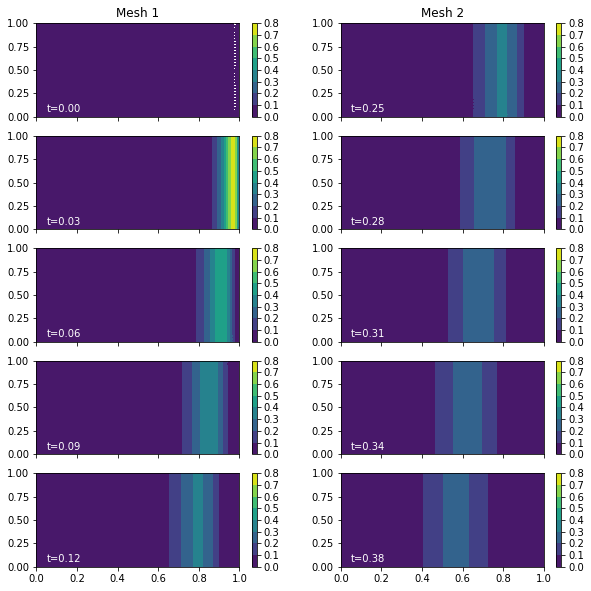

In [12]:
plot_adj_solutions(adj_sols_same_mesh)

The restarts work nicely in the case where the two meshes are identical. (Compare with the plots at the end of [this notebook](https://github.com/firedrakeproject/firedrake/blob/master/docs/notebooks/11-extract-adjoint-solutions.ipynb).)

Now try different meshes.

In [13]:
meshes = [left_mesh, right_mesh]
function_spaces = [VectorFunctionSpace(mesh, "CG", 2) for mesh in meshes]

In [14]:
adj_sols_different_mesh = solve_adjoint(solve_burgers_step, ic_burgers, qoi_burgers, function_spaces)

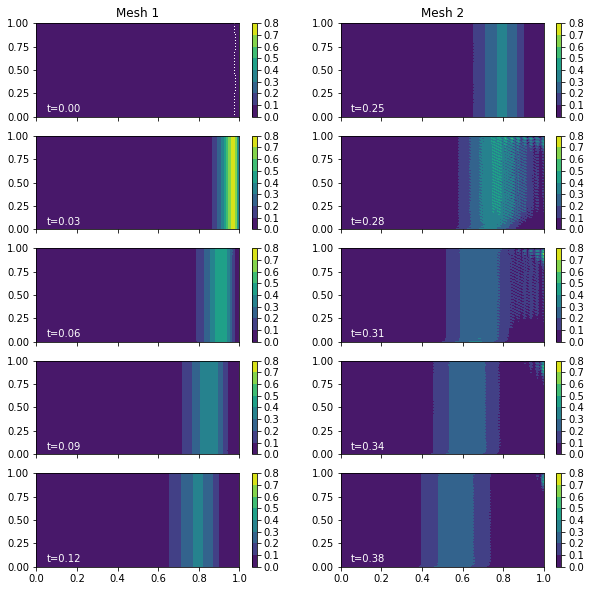

In [15]:
plot_adj_solutions(adj_sols_different_mesh)

Relative error = 14.5573%


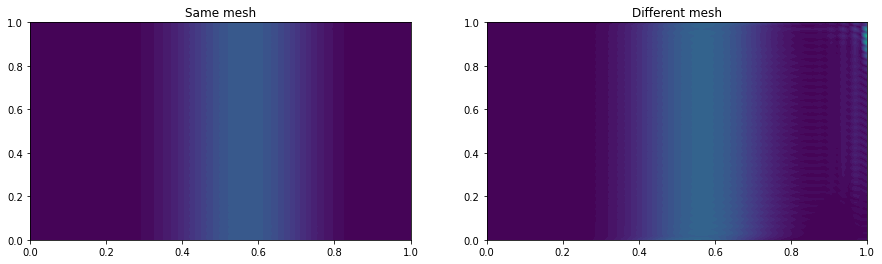

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
levels = np.linspace(0, 0.8, 50)
adj_same_mesh = adj_sols_same_mesh[-1][-1]
adj_different_mesh = adj_sols_different_mesh[-1][-1]
axes[0].set_title("Same mesh")
tricontourf(adj_same_mesh, axes=axes[0], levels=levels)
axes[1].set_title("Different mesh")
tricontourf(adj_different_mesh, axes=axes[1], levels=levels)
print(f"Relative error = {errornorm(adj_same_mesh, adj_different_mesh)/norm(adj_same_mesh)*100:.4f}%")

Clearly, the mesh-to-mesh projection has effected the adjoint solution.
However, the resemblance is reasonable.